## Premier league 2022-2023

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import os.path
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from adjustText import adjust_text

#### Setup Chrome Driver Driver and Data Scraping

In [4]:
## Setup chrome options
chrome_options = Options()
chrome_options.add_argument("--headless") # Ensure GUI is off
chrome_options.add_argument("--no-sandbox")

# Set path to chromedriver as per your configuration
homedir = os.path.expanduser("~")
webdriver_service = Service(f"{homedir}/chromedriver/stable/chromedriver")

# Choose Chrome Browser
browser = webdriver.Chrome(service=webdriver_service, options=chrome_options)

#### Scraping English Premier League Data

1. [EPL 2020-2021](https://dataviz.theanalyst.com/season-reviews/2020/)
2. [EPL 2021-2022](https://dataviz.theanalyst.com/season-reviews-2021/?competitionId=8&seasonId=2021)
3. [EPL 2022-2023](https://dataviz.theanalyst.com/football-season-metrics/?competitionId=8&seasonId=2022)

In [34]:
# Get page
browser.get("https://dataviz.theanalyst.com/season-reviews/2020/")

# Get Toggle By 90 and click
team_sequence = browser.find_element(By.CSS_SELECTOR, 'div[id="Team_Sequences_Pressure"]')
team_sequence.click()

page_source = BeautifulSoup(browser.page_source, 'lxml')

# Get the data in the script
raw_table = page_source.find_all('table')

In [35]:
raw_table

[<table class="data-table" style="border-collapse: collapse;"><thead><tr><th></th><th></th><th></th><th class="top-row-header" colspan="3">High Turnovers</th></tr><tr class="col-row"><th class="headers" id="pos">pos</th><th class="headers" id="team">team</th><th class="headers" id="PPDA">PPDA</th><th class="headers" id="total">total</th><th class="headers" id="shot_ending">shot ending</th><th class="headers" id="goal_ending">goal ending</th></tr></thead><tbody class="data-table-body"><tr class="data-row"><td class="pos-td"><div class="pos">1</div></td><td class="team-td"><div class="team"><span class="badge-span"><img class="badge" height="20" src="https://omo.akamai.opta.net/image.php?secure=true&amp;h=omo.akamai.opta.net&amp;sport=football&amp;entity=team&amp;description=badges&amp;dimensions=150&amp;id=43" width="20"/></span><div class="team-name">Manchester City</div><div class="team-name-short">Man City</div></div></td><td class="PPDA-td data-td"><div class="PPDA pill" style="back

### Team Sequence (Style)

#### Normalize and parse it to csv

In [38]:
def convert_df(table):
    clubs_epl_head = []
    clubs_epl = []

    for club_row in table.thead:
        club_head = []
        for col in club_row:
            club_head.append(col.text)
            col_size = col.get("colspan")
            if col_size != None:
                count = int(col_size)-1
                while count != 0:
                    club_head.append(col.text)
                    count -= 1
        clubs_epl_head.append(club_head)

    for club_row in table.tbody:
        club = []
        for idx, col in enumerate(club_row):
            if idx > 1:
                club.append(float(col.text))
            # Comment this if not 20/21 season
            elif idx == 1:
                club.append(col.div.div.text) 
            else:
                club.append(col.text)
        clubs_epl.append(club)

    return pd.DataFrame(clubs_epl, columns=clubs_epl_head)

data_epl = convert_df(raw_table[0])

data_epl

High Turnovers                        
   pos                      team  PPDA          total shot ending goal ending
0    1           Manchester City  11.5          377.0        80.0        11.0
1    2         Manchester United  11.9          289.0        46.0         4.0
2    3                 Liverpool  10.4          367.0        67.0         4.0
3    4                   Chelsea  10.4          275.0        39.0         2.0
4    5            Leicester City  11.2          289.0        52.0         7.0
5    6           West Ham United  17.0          234.0        28.0         2.0
6    7         Tottenham Hotspur  12.4          228.0        37.0         5.0
7    8                   Arsenal  14.3          266.0        41.0         6.0
8    9              Leeds United   9.3          274.0        41.0         5.0
9   10                   Everton  14.8          244.0        27.0         2.0
10  11               Aston Villa  12.4          265.0        41.0         9.0
11  12          Newcastle United  18.3          180.0        40.0         5.0
12  13   Wolverhampton Wanderers  15.5          205.0        42.0         1.0
13  14            Crystal Palace  16.6          248.0        29.0         0.0
14  15               Southampton  11.2          282.0        36.0         3.0
15  16  Brighton and Hove Albion  11.5          321.0        58.0         3.0
16  17                   Burnley  14.6          296.0        43.0         5.0
17  18                    Fulham  13.4          294.0        40.0         4.0
18  19      West Bromwich Albion  17.4          279.0        41.0         5.0
19  20          Sheffield United  14.9          235.0        22.0         2.0

In [39]:
data_epl.to_csv("../data/epl-20-21-team-pressures.csv")

### Team style of play

#### Load the data from CSV

In [32]:
epl_20_21 = pd.read_csv("../data/epl-20-21-team-style.csv")
epl_21_22 = pd.read_csv("../data/epl-21-22-team-style.csv")
epl_22_23 = pd.read_csv("../data/epl-22-23-team-style.csv")

def promote_df_headers(df):
    new_header = df.iloc[0] 
    df = df[1:] 
    df.columns = new_header
    df = df.reset_index(drop=True)

    return df

epl_20_21 = promote_df_headers(epl_20_21)
epl_21_22 = promote_df_headers(epl_21_22)
epl_22_23 = promote_df_headers(epl_22_23)

#### Combine 2 CSV

In [33]:
epl_20_21['season'] = "20/21"
epl_21_22['season'] = "21/22"
epl_22_23['season'] = "22/23"

epl_df = [epl_20_21, epl_21_22, epl_22_23]

data_epl = pd.concat(epl_df)

In [92]:
epl_21_22

,pos,team,sequence time,passes per sequence,direct speed,10+ pass OP sequences,build up attacks,direct attacks,season
0,1,Manchester City,15.29,5.32,1.09,916.0,282.0,67.0,21/22
1,2,Liverpool,10.93,4.25,1.54,688.0,166.0,93.0,21/22
2,3,Chelsea,12.26,4.63,1.33,734.0,165.0,79.0,21/22
3,4,Tottenham Hotspur,10.91,4.04,1.35,528.0,127.0,66.0,21/22
4,5,Arsenal,10.78,3.88,1.19,498.0,109.0,60.0,21/22
5,6,Manchester United,9.99,3.84,1.58,439.0,102.0,69.0,21/22
6,7,West Ham United,9.22,3.5,1.52,380.0,69.0,60.0,21/22
7,8,Leicester City,9.59,3.7,1.33,462.0,89.0,72.0,21/22
8,9,Brighton and Hove Albion,9.74,3.61,1.21,455.0,80.0,40.0,21/22
9,10,Wolverhampton Wanderers,9.36,3.49,1.43,373.0,61.0,65.0,21/22


In [34]:
data_epl['direct attacks'] = data_epl['direct attacks'].astype(float)
data_epl['build up attacks'] = data_epl['build up attacks'].astype(float)
data_epl['season'] = data_epl['season'].astype(str)

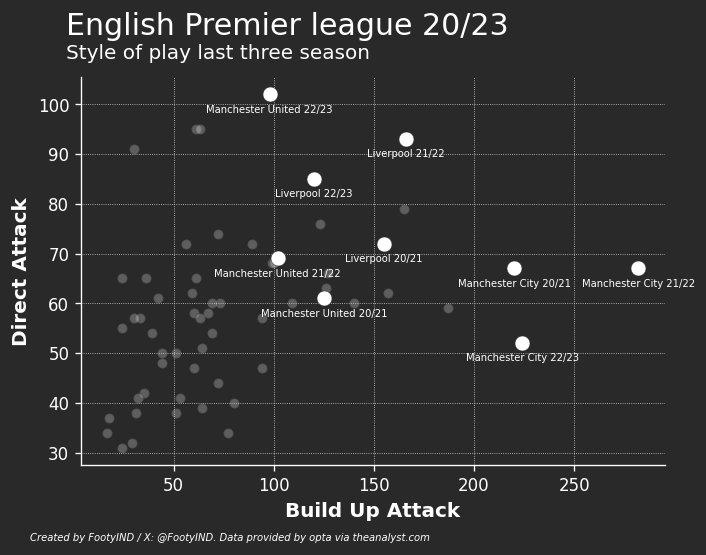

In [39]:
# Teams Higlight
team = "Manchester United"
teams = {"Manchester United", "Manchester City", "Liverpool"}

## Theme
bg = "#292929"
filler = "grey"
text_color = "w"
title_font = "Alegreya Sans"

# Spines Label X & Y
mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

fig, ax = plt.subplots(figsize=(6, 4), dpi=120)
fig.set_facecolor(bg)
ax.patch.set_alpha(0)

ax.grid(ls="dotted",lw="0.5",color="lightgrey", zorder=1)

x = data_epl['build up attacks'].values.tolist()
y = data_epl['direct attacks'].values.tolist()

ax.scatter(x, y, edgecolors=bg, color=text_color, alpha=0.25)

x = data_epl[data_epl['team'].isin(teams)]['build up attacks'].values.tolist()
y = data_epl[data_epl['team'].isin(teams)]['direct attacks'].values.tolist()
t = data_epl[data_epl['team'].isin(teams)]['team'].values.tolist()
s = data_epl[data_epl['team'].isin(teams)]['season'].values.tolist()

ax.scatter(x,y, zorder=3, color=text_color)

ax.scatter(x,y,s=80,color=text_color, edgecolors=bg, alpha=1, lw=.25, zorder=4)
for i, txt in enumerate(t):
    team_season = "{} {}"
    ax.annotate(team_season.format(t[i], s[i]), (x[i], y[i]-2), ha="center", va="top", color=text_color, fontsize=6)

spines = ["top","right","bottom","left"]
for s in spines:
    if s in ["top","right"]:
        ax.spines[s].set_visible(False)
    else:
        ax.spines[s].set_color(text_color)
        

## Title & comment
fig.text(.1, 1.05,'English Premier league 20/23',size=18, color=text_color)
fig.text(.1, 1,'Style of play last three season', size=12, color=text_color)

ax.set_xlabel("Build Up Attack", fontweight="bold", fontsize=12, color=text_color)
ax.set_ylabel("Direct Attack", fontweight="bold", fontsize= 12, color=text_color)

fig.text(0.05, -0.005, "Created by FootyIND / X: @FootyIND. Data provided by opta via theanalyst.com",
        fontstyle="italic",fontsize=6, color=text_color)

plt.tight_layout()
plt.show()
fig.savefig('../images/epl-direct-vs-build-up.png', bbox_inches='tight')

### EPL Pressing Intensity

In [40]:
epl_pressing_22_23 = pd.read_csv("../data/epl-22-23-team-pressures.csv")

def promote_df_headers(df):
    new_header = df.iloc[0] 
    df = df[1:] 
    df.columns = new_header
    df = df.reset_index(drop=True)

    return df

epl_pressing_22_23 = promote_df_headers(epl_pressing_22_23)

In [6]:
epl_pressing_22_23

,NaN,pos,team,PPDA,total,shot ending,goal ending
0,0.0,1,Manchester City,11.7,363.0,50.0,9.0
1,1.0,2,Arsenal,11.0,388.0,62.0,9.0
2,2.0,3,Manchester United,12.3,328.0,61.0,4.0
3,3.0,4,Newcastle United,10.5,325.0,36.0,5.0
4,4.0,5,Liverpool,10.4,368.0,52.0,4.0
5,5.0,6,Brighton and Hove Albion,10.2,345.0,67.0,6.0
6,6.0,7,Aston Villa,12.7,293.0,46.0,4.0
7,7.0,8,Tottenham Hotspur,13.8,255.0,46.0,9.0
8,8.0,9,Brentford,12.7,271.0,43.0,9.0
9,9.0,10,Fulham,13.9,263.0,37.0,4.0


In [41]:
epl_pressing_22_23['PPDA'] = epl_pressing_22_23['PPDA'].astype(float)
epl_pressing_22_23['total'] = epl_pressing_22_23['total'].astype(float)

epl_pressing_22_23.sort_values('total', ascending=True, inplace=True)

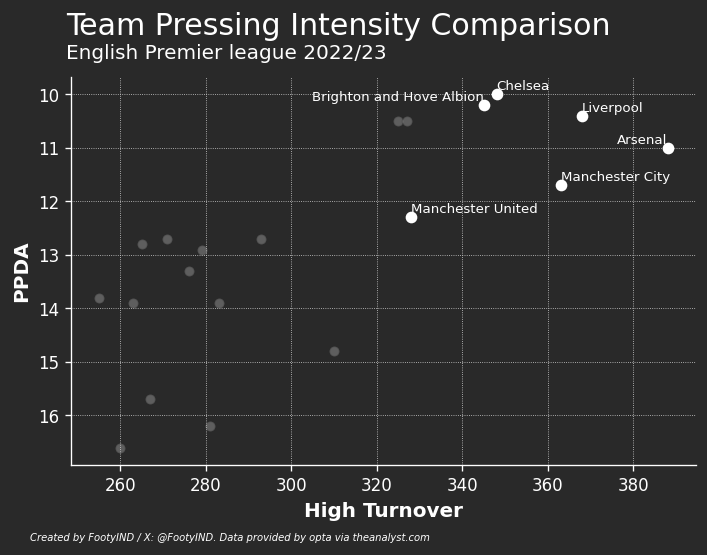

In [42]:
# Teams Higlight
team = "Manchester United"
teams = {"Manchester United", "Manchester City", "Liverpool", "Arsenal"}

## Theme
bg = "#292929"
filler = "grey"
text_color = "w"
title_font = "Alegreya Sans"

# Spines Label X & Y
mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

fig, ax = plt.subplots(figsize=(6, 4), dpi=120)
fig.set_facecolor(bg)
ax.patch.set_alpha(0)

ax.grid(ls="dotted",lw="0.5",color="lightgrey", zorder=1)

x = epl_pressing_22_23['total'].values.tolist()
y = epl_pressing_22_23['PPDA'].values.tolist()

ax.scatter(x, y, edgecolors=bg, color=text_color, alpha=0.25)

team_condition = (epl_pressing_22_23['total'] >= 328.0) & (epl_pressing_22_23['PPDA'] <= 12.3)

x = epl_pressing_22_23[team_condition]['total'].values.tolist()
y = epl_pressing_22_23[team_condition]['PPDA'].values.tolist()
t = epl_pressing_22_23[team_condition]['team'].values.tolist()

ax.scatter(x, y, zorder=3, color=text_color )

# ax.scatter(x,y,s=80,color=text_color, edgecolors=bg, alpha=1, lw=.25, zorder=4)
# for i, txt in enumerate(t):
#     ax.annotate(t[i], (x[i], y[i]+0.2), ha="center", va="top", color=text_color, fontsize=6)

spines = ["top","right","bottom","left"]
for s in spines:
    if s in ["top","right"]:
        ax.spines[s].set_visible(False)
    else:
        ax.spines[s].set_color(text_color)
        

## Title & comment
fig.text(.1, 1.05,'Team Pressing Intensity Comparison',size=18, color=text_color)
fig.text(.1, 1,'English Premier league 2022/23', size=12, color=text_color)


## X and Y axes
ax.set_xlabel("High Turnover", fontweight="bold", fontsize=12, color=text_color)
ax.set_ylabel("PPDA", fontweight="bold", fontsize= 12, color=text_color)

ax.invert_yaxis()

## Credit
fig.text(0.05, -0.005, "Created by FootyIND / X: @FootyIND. Data provided by opta via theanalyst.com",
        fontstyle="italic",fontsize=6, color=text_color)

texts = []

for x, y, s in zip(x, y, t):
    texts.append(ax.annotate(s, (x, y), color=text_color, fontsize=8))
adjust_text(texts, 
            only_move={'points':'y', 'texts':'y'})

plt.tight_layout()
plt.show()
fig.savefig('../images/epl-pressing-intensity.png', bbox_inches='tight')